# Given certain features we have to predict whether 

Dataset - https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump

from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, f1_score, plot_roc_curve, f1_score, roc_auc_score, plot_roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump, load

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import RBFSampler





## Import Data 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Airline-Delay/data/airlines.csv")

In [ ]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [ ]:
df.corr()

,id,Flight,DayOfWeek,Time,Length,Delay
id,1.000000,-0.006156,-0.055474,0.029156,0.020781,0.139762
Flight,-0.006156,1.000000,0.000416,-0.005750,-0.341481,-0.046175
DayOfWeek,-0.055474,0.000416,1.000000,0.001273,0.013397,-0.026199
Time,0.029156,-0.005750,0.001273,1.000000,-0.020612,0.150454
Length,0.020781,-0.341481,0.013397,-0.020612,1.000000,0.040489
Delay,0.139762,-0.046175,-0.026199,0.150454,0.040489,1.000000


In [ ]:
df_temp = df.drop(["id", "Airline"], axis = 1)

In [ ]:
df_temp.head()

,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,269,SFO,IAH,3,15,205,1
1,1558,PHX,CLT,3,15,222,1
2,2400,LAX,DFW,3,20,165,1
3,2466,SFO,DFW,3,20,195,1
4,108,ANC,SEA,3,30,202,0


In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Flight       539383 non-null  int64 
 1   AirportFrom  539383 non-null  object
 2   AirportTo    539383 non-null  object
 3   DayOfWeek    539383 non-null  int64 
 4   Time         539383 non-null  int64 
 5   Length       539383 non-null  int64 
 6   Delay        539383 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 28.8+ MB


In [ ]:
df_temp.isna().sum()

Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [ ]:
df_temp.Delay.value_counts()

0    299119
1    240264
Name: Delay, dtype: int64

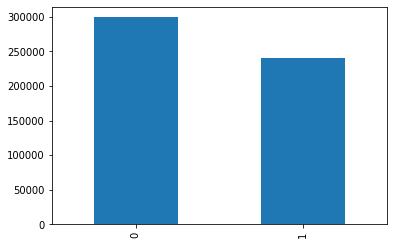

In [ ]:
df_temp.Delay.value_counts().plot(kind = 'bar')

The label distribution is comparable

In [ ]:
df_temp.DayOfWeek.value_counts()

4    91445
3    89746
5    85248
1    72769
2    71340
7    69879
6    58956
Name: DayOfWeek, dtype: int64

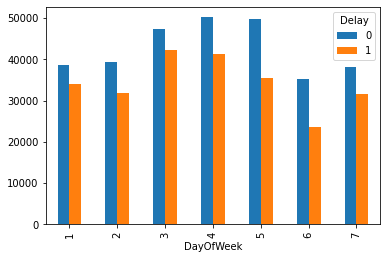

In [ ]:
pd.crosstab(df_temp.DayOfWeek, df_temp.Delay).plot(kind = "bar");

No correlation between day of the week and delay 


In [ ]:
df_temp.AirportTo.value_counts()

ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportTo, Length: 293, dtype: int64

In [ ]:
df_temp.Time

0           15
1           15
2           20
3           20
4           30
          ... 
539378    1439
539379    1439
539380    1439
539381    1439
539382    1439
Name: Time, Length: 539383, dtype: int64

In [ ]:
def plot_time_delay_graph(xmin, xmax, xstep):
  plt.figure(figsize = (10,10))
  plt.plot(pd.crosstab(df_temp.Time[(df_temp.Time<xmax) & (df_temp.Time>xmin)], df_temp.Delay), )
  plt.xticks(list(range(xmin, xmax,xstep)));
  plt.legend([0,1])




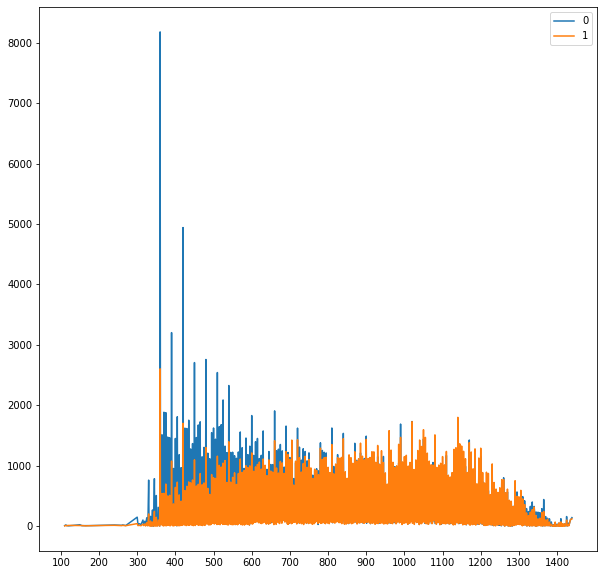

In [ ]:
plot_time_delay_graph(100,1500,100);

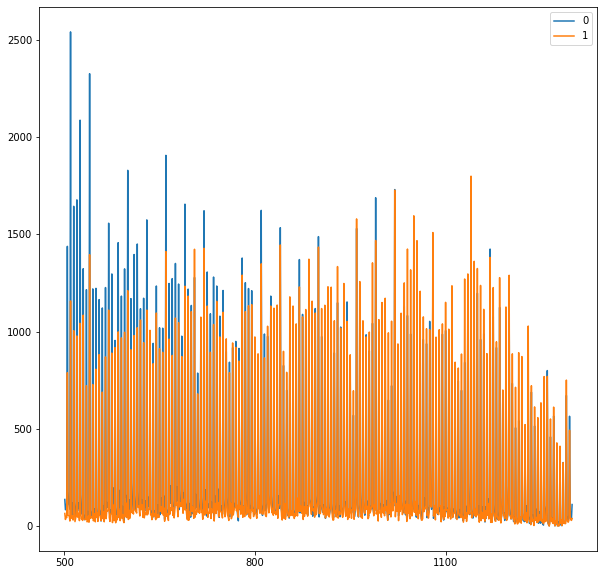

In [ ]:
plot_time_delay_graph(500,1300,300);

Assuming time is in minutes , we can see that Flights with duration of greater than 800 minutes have more concentration of delays. The ration of Delay/On-Tine is sometimes grater than 1 i:e there are more delays than on time flight   




In [ ]:
pd.crosstab(df_temp.AirportFrom, df_temp.Delay)

Delay,0,1
AirportFrom,,
ABE,232,110
ABI,179,32
ABQ,1424,1375
ABR,1,1
ABY,65,22
...,...,...
VPS,423,210
WRG,41,18
XNA,811,317


## Diving data into Labels and feature and training and test data and One Hot encodeing data

In [ ]:
X = df_temp.drop('Delay', axis =1 )
y = df_temp.Delay


In [ ]:
X.head()

,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length
0,269,SFO,IAH,3,15,205
1,1558,PHX,CLT,3,15,222
2,2400,LAX,DFW,3,20,165
3,2466,SFO,DFW,3,20,195
4,108,ANC,SEA,3,30,202


### One Hot encoding

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Flight       539383 non-null  int64 
 1   AirportFrom  539383 non-null  object
 2   AirportTo    539383 non-null  object
 3   DayOfWeek    539383 non-null  int64 
 4   Time         539383 non-null  int64 
 5   Length       539383 non-null  int64 
 6   Delay        539383 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 28.8+ MB


In [ ]:
categorical_features = ["AirportFrom", "AirportTo"]
one_hot_encoder = OneHotEncoder(sparse = False)
transformer = ColumnTransformer([("one_hot_encoder", one_hot_encoder, categorical_features)], remainder="passthrough")

transformed_X = transformer.fit_transform(X)
transformed_X

array([[   0.,    0.,    0., ...,    3.,   15.,  205.],
       [   0.,    0.,    0., ...,    3.,   15.,  222.],
       [   0.,    0.,    0., ...,    3.,   20.,  165.],
       ...,
       [   0.,    0.,    0., ...,    5., 1439.,  255.],
       [   0.,    0.,    0., ...,    5., 1439.,  313.],
       [   0.,    0.,    0., ...,    5., 1439.,  301.]])

In [ ]:
len(X.AirportFrom.unique())+ len(X.AirportTo.unique())

586

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size = 0.2)
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((431506, 590), (431506,), (107877, 590), (107877,))

## Training Models and getting there scores

In [ ]:
models = {
    "SGDClassifier": SGDClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

NUM_TRAIN = 80000
NUM_TEST = 10000

In [ ]:
def fit_score_models(models,X_train, y_train, X_test, y_test, num_test, num_train):
  model_scores = {}

  for name, model in models.items():
    model.fit(X_train[:num_train], y_train[:num_train])

    model_scores[name] = {}

    y_preds = model.predict(X_test[:num_test])
    model_scores[name]["Accuracy"] = accuracy_score(y_test[:num_test], y_preds)

    model_scores[name]["Recall"] = recall_score(y_test[:num_test], y_preds)
    model_scores[name]["Precision"]= precision_score(y_test[:num_test], y_preds)
    model_scores[name]["F1_Score"] = f1_score(y_test[:num_test],y_preds)
    model_scores[name]["Classification_Report"] = classification_report(y_test[:num_test], y_preds, digits = 2)
    model_scores[name]["ROC-AUC-Score"] = roc_auc_score(y_test[:num_test], y_preds)



  return model_scores  
                                                        
                                                                        



In [ ]:
scores = fit_score_models(models =models , X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, num_test = NUM_TEST, num_train = NUM_TRAIN)
scores

[0 0 0 ... 0 0 0]
[1 0 1 ... 0 1 0]


{'RandomForestClassifier': {'Accuracy': 0.6133,
  'Classification_Report': '              precision    recall  f1-score   support\n\n           0       0.64      0.68      0.66      5519\n           1       0.57      0.53      0.55      4481\n\n    accuracy                           0.61     10000\n   macro avg       0.61      0.61      0.61     10000\nweighted avg       0.61      0.61      0.61     10000\n',
  'F1_Score': 0.549877779071121,
  'Precision': 0.5746958637469587,
  'ROC-AUC-Score': 0.6051952195816696,
  'Recall': 0.5271144833742468},
 'SGDClassifier': {'Accuracy': 0.5535,
  'Classification_Report': '              precision    recall  f1-score   support\n\n           0       0.55      0.97      0.71      5519\n           1       0.52      0.04      0.07      4481\n\n    accuracy                           0.55     10000\n   macro avg       0.54      0.51      0.39     10000\nweighted avg       0.54      0.55      0.42     10000\n',
  'F1_Score': 0.07075962539021852,
  'Preci

### RBF Sampler

In [ ]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
clf = SGDClassifier(max_iter=5)
clf.fit(X_features, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


SGDClassifier(max_iter=5)

In [ ]:
X_test_features = rbf_feature.fit_transform(X_test)
clf.score(X_test_features, y_test)

0.5564207384335864

In [ ]:
def get_test_scores(model, X_test, y_test):

  np.random.seed(3)
  scores = {}
  y_preds = model.predict(X_test)
  print(set(y_test) - set(y_preds))

  scores['Accuracy'] = accuracy_score(y_test,y_preds)
  scores['F1-Score'] = f1_score(y_test, y_preds)
  scores['Precision'] = precision_score(y_test, y_preds)
  scores['Recall'] = recall_score(y_test, y_preds)
  scores['ROC-AUC-Score'] = roc_auc_score(y_test, y_preds)

  return scores

In [ ]:
get_test_scores(model = clf, X_test = X_test_features,y_test = y_test )

{1}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.5564207384335864,
 'F1-Score': 0.0,
 'Precision': 0.0,
 'ROC-AUC-Score': 0.5,
 'Recall': 0.0}

In [ ]:
y_preds = clf.predict(X_features)
np.unique(y_preds)

array([0])

In [ ]:
np.unique(y_test)

array([0, 1])

In [ ]:
df_temp.index[df_temp.Delay == 1]


Int64Index([     0,      1,      2,      3,      5,      8,      9,     10,
                11,     23,
            ...
            539360, 539361, 539363, 539365, 539370, 539373, 539376, 539377,
            539381, 539382],
           dtype='int64', length=240264)

In [ ]:
df_temp.head()

,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,269,SFO,IAH,3,15,205,1
1,1558,PHX,CLT,3,15,222,1
2,2400,LAX,DFW,3,20,165,1
3,2466,SFO,DFW,3,20,195,1
4,108,ANC,SEA,3,30,202,0


In [ ]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_preds = rfc_model.predict(X_test)

In [ ]:
rfc_score =  get_test_scores(model = rfc_model, X_test =X_test, y_test = y_test)

rfc_score

set()


{'Accuracy': 0.6193720626268806,
 'F1-Score': 0.5630739436245038,
 'Precision': 0.5736151761517615,
 'ROC-AUC-Score': 0.612633167524064,
 'Recall': 0.5529131488757001}

In [ ]:
rfr_grid = {
    "n_estimators": [100, 150,200],
     "max_depth": [None, 10],
    "min_samples_split": [2,4],
    "min_samples_leaf":[1,2,]
}

In [ ]:
np.random.seed(3)

rfr_grid_model = GridSearchCV(RandomForestClassifier(), param_grid=rfr_grid, cv=5, verbose = True)

rfr_grid_model.fit(X_train[:100000], y_train[:100000])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 150, 200]},
             verbose=True)

In [ ]:
rfr_grid_model.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
y_preds = rfr_grid_model.predict(X_test)

In [ ]:
rfc_scores = get_test_scores(model =rfr_grid_model, X_test = X_test, y_test = y_test )
rfc_scores

set()


{'Accuracy': 0.6467551007165568,
 'F1-Score': 0.5584817342339732,
 'Precision': 0.6277773436482509,
 'ROC-AUC-Score': 0.6323169353128119,
 'Recall': 0.5029633958011603}

In [ ]:
dump(rfr_grid_model, '/content/drive/MyDrive/Machine Learning/Airline-Delay/models/Random-Forest_Classifier_150.sav')

['/content/drive/MyDrive/Machine Learning/Airline-Delay/models/Random-Forest_Classifier_150.sav']